## First steps with TensorFlow

2 kinds of API's:
* TF api - Low Level Tensor manipulation, Backpropagation
* Keras Api - Layers, loss function, metrics, optimizers, etc.

#### Constant tensors and variables

**All-ones or all-zeros tensors**

In [1]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [2]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Random tensors**

In [3]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-0.41931823]
 [-0.39578807]
 [-0.05480471]], shape=(3, 1), dtype=float32)


In [4]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.04200375]
 [0.31570065]
 [0.8368591 ]], shape=(3, 1), dtype=float32)


**NumPy arrays are assignable**

In [5]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.
x

array([[0., 1.],
       [1., 1.]])

In [6]:
x = tf.zeros(shape=(2, 1))
x[0, 0] = 1.
x

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

**Creating a TensorFlow variable**

In [7]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 1.5327947 ],
       [ 0.26850736],
       [-1.0105714 ]], dtype=float32)>


**Assigning a value to a TensorFlow variable**

In [8]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Assigning a value to a subset of a TensorFlow variable**

In [9]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Using `assign_add`**

In [10]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Tensor operations: Doing math in TensorFlow

**A few basic math operations**

In [11]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d # element-wise mult

#### A second look at the GradientTape API

**Using the `GradientTape`**

In [12]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
gradient

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

**Using `GradientTape` with constant tensor inputs**

In [13]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

**Using nested gradient tapes to compute second-order gradients**

In [14]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

#### An end-to-end example: A linear classifier in pure TensorFlow

**Generating two classes of random points in a 2D plane**

In [15]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

**Stacking the two classes into an array with shape (2000, 2)**

In [16]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [17]:
inputs

array([[-0.35601336,  2.6262255 ],
       [ 0.8638109 ,  2.1452916 ],
       [ 0.0682007 ,  2.906966  ],
       ...,
       [ 3.1467545 , -0.16021883],
       [ 4.272392  ,  1.0748638 ],
       [ 2.5402377 ,  0.13335794]], dtype=float32)

**Generating the corresponding targets (0 and 1)**

In [18]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

**Plotting the two point classes**

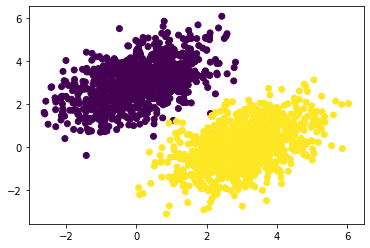

In [19]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creating the linear classifier variables**

In [20]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**The forward pass function**

In [21]:
def model(inputs):
    return tf.matmul(inputs, W) + b #Wx + b

**The mean squared error loss function**

In [22]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**The training step function**

In [23]:
learning_rate = 0.1

# := simultaneous update

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**The batch training loop**

In [24]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 3.5045
Loss at step 1: 0.3863
Loss at step 2: 0.1563
Loss at step 3: 0.1183
Loss at step 4: 0.1069
Loss at step 5: 0.0996
Loss at step 6: 0.0933
Loss at step 7: 0.0875
Loss at step 8: 0.0823
Loss at step 9: 0.0775
Loss at step 10: 0.0731
Loss at step 11: 0.0691
Loss at step 12: 0.0654
Loss at step 13: 0.0621
Loss at step 14: 0.0590
Loss at step 15: 0.0562
Loss at step 16: 0.0536
Loss at step 17: 0.0512
Loss at step 18: 0.0490
Loss at step 19: 0.0470
Loss at step 20: 0.0452
Loss at step 21: 0.0435
Loss at step 22: 0.0420
Loss at step 23: 0.0406
Loss at step 24: 0.0393
Loss at step 25: 0.0381
Loss at step 26: 0.0370
Loss at step 27: 0.0360
Loss at step 28: 0.0351
Loss at step 29: 0.0343
Loss at step 30: 0.0335
Loss at step 31: 0.0328
Loss at step 32: 0.0322
Loss at step 33: 0.0316
Loss at step 34: 0.0311
Loss at step 35: 0.0306
Loss at step 36: 0.0301
Loss at step 37: 0.0297
Loss at step 38: 0.0293
Loss at step 39: 0.0290


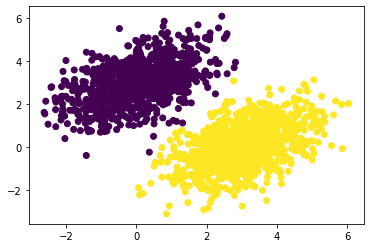

In [25]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

In [26]:
W

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 0.18123305],
       [-0.11798657]], dtype=float32)>

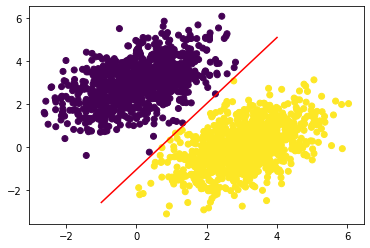

In [27]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomy of a neural network: Understanding core Keras APIs

### Layers: The building blocks of deep learning

#### The base Layer class in Keras

**A `Dense` layer implemented as a `Layer` subclass**

In [31]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [32]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


#### Automatic shape inference: Building layers on the fly

In [33]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [34]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [38]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### From layers to models

### The "compile" step: Configuring the learning process

In [42]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [43]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the fit() method

**Calling `fit()` with NumPy data**

In [44]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 0s 1ms/step - loss: 20.7892 - binary_accuracy: 0.0030
Epoch 2/5
16/16 [==============================] - 0s 934us/step - loss: 20.2332 - binary_accuracy: 0.0030
Epoch 3/5
16/16 [==============================] - 0s 1ms/step - loss: 19.7580 - binary_accuracy: 0.0030
Epoch 4/5
16/16 [==============================] - 0s 1ms/step - loss: 19.2988 - binary_accuracy: 0.0030
Epoch 5/5
16/16 [==============================] - 0s 867us/step - loss: 18.8465 - binary_accuracy: 0.0030


In [45]:
history.history

{'loss': [20.789188385009766,
  20.233152389526367,
  19.757953643798828,
  19.298799514770508,
  18.846542358398438],
 'binary_accuracy': [0.003000000026077032,
  0.003000000026077032,
  0.003000000026077032,
  0.003000000026077032,
  0.003000000026077032]}

### Monitoring loss and metrics on validation data

**Using the `validation_data` argument**

In [46]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 0s 2ms/step - loss: 0.4335 - binary_accuracy: 0.8571 - val_loss: 0.2453 - val_binary_accuracy: 0.6867
Epoch 2/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0679 - binary_accuracy: 0.9543 - val_loss: 0.0284 - val_binary_accuracy: 0.9967
Epoch 3/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0766 - binary_accuracy: 0.9557 - val_loss: 0.0322 - val_binary_accuracy: 0.9950
Epoch 4/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0684 - binary_accuracy: 0.9550 - val_loss: 0.0421 - val_binary_accuracy: 0.9883
Epoch 5/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0725 - binary_accuracy: 0.9621 - val_loss: 0.0779 - val_binary_accuracy: 0.9400


### Inference: Using a model after training

In [47]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

[[ 0.66944695]
 [ 0.10415921]
 [ 0.63496166]
 [ 0.6809905 ]
 [ 0.555547  ]
 [-0.12914073]
 [ 0.09908372]
 [ 0.7300159 ]
 [ 0.61602944]
 [ 0.9368454 ]]
